<h1> Illinois State Booking Data </h1>

Source(s):
https://www.kaggle.com/datasets/rishidamarla/prison-data-from-the-state-of-illinois

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

<h2>Data Verification & Handling</h2>

In [2]:
df = pd.read_csv('Illinois/jail-booking-data-1.csv', low_memory=False)
plt.rcParams["font.size"] = "16"
# Getting rid of data that is not of interest currently.
dpTables = ['marital_status', 
            'maritial_status', 
            'STATE', 
            'city', 
            'military', 
            'jacket_type', 
            'arrest_agency', 
            'statute', 
            'occupation',
            'finalanswercode',
            'release_reason_description',
            'hours',
            'booking_time',
            'released_time',
            'jacket_number',
            'zip_code',
            'prisoner_type',
            'finalanswerdesc',
            'age_at_release',
            'school',
            'released_date'] # might re-add age at release, but we do have days in jail, which is more granular anyway.

df = df.drop(dpTables,1)

pat = '\d+/\d+/(\d{4})$' 
df['booking_year']=df['booking_date'].str.extract(pat)

# replace null entries with 'UNKNOWN'
for col in df:
    df[col] = df[col].fillna('UNKNOWN')

df.isnull().sum().sort_values(ascending=False)

booking_number       0
booking_date         0
release_reason       0
booking_reason       0
incarc_reason        0
inmate_status        0
custody_class        0
superhighlevel       0
crime                0
education_status     0
offense_level        0
citizenship          0
sex                  0
race                 0
employment_status    0
days_in_jail         0
age_at_arrest        0
booking_year         0
dtype: int64

In [3]:
bookings = df.groupby('booking_reason')

#No warrant
noWarrant = bookings.get_group('Arrested Without Warrant')

# Arrested on a Warrant
T1 = 'Arrested on Warrant'
T2 = 'Arrested on Warrant -- !! break down later, FTA vs. Arrest'
warrant = pd.concat([bookings.get_group(T1), bookings.get_group(T2)])

# Sentenced, this will be our focus later
T3 = 'Sentenced'
T4 = 'Sentenced to DOC'
T5 = 'Sentenced to EHD'
sentenced = pd.concat([
    bookings.get_group(T3), 
    bookings.get_group(T4), 
    bookings.get_group(T5)])    

#Other
T6 = 'Court Action (remanded, writs)'
T7 = 'NOT CLASSIFIED'
T8 = 'UNKNOWN'
T9 = 'Book and Release - NEW'
other = pd.concat([
    bookings.get_group(T6), 
    bookings.get_group(T7), 
    bookings.get_group(T8), 
    bookings.get_group(T9)])

<h1>Data Analysis</h1>

The following data shows that: <br>
1) The overlap between sets is not significant, in light of there being thousands of entries, 20 overlapping is not even vaguely significant.
<br><br>
2) The majority of bookings are sentencings or warrants for arrest, which may be more than anticipated. The remaining 23% includes everything else, which is a pretty wide net.

Overlap between Sentenced and Warrant: 16
Overlap between Sentenced and Other: 4


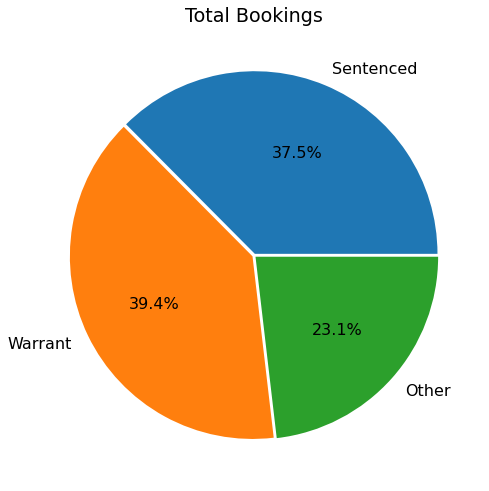

In [4]:
# Not all entries are for one specific individual, so we need to handle that.
sentenced = sentenced.drop_duplicates(subset=["booking_number"], keep="first")
warrant = warrant.drop_duplicates(subset=["booking_number"], keep="first")
other = other.drop_duplicates(subset=["booking_number"], keep="first")

Totals_Labels = ["Sentenced", "Warrant", "Other"]
Totals = [len(sentenced), len(warrant), len(other)]

# Now we want to see if there's any overlap between sets
overlap_sw = np.intersect1d(sentenced["booking_number"], warrant["booking_number"])
overlap_so = np.intersect1d(sentenced["booking_number"], other["booking_number"])

print("Overlap between Sentenced and Warrant: " + str(len(overlap_sw)))
print("Overlap between Sentenced and Other: " + str(len(overlap_so)))

fig = plt.figure(figsize = (18,30))
grid = plt.GridSpec(1,2, hspace = 0.3, wspace = 0.2, figure = fig)

fig.add_subplot(grid[0,0], title = "Total Bookings")
plt.pie(Totals, labels = Totals_Labels, autopct='%1.1f%%', textprops={'fontsize': 16}, explode = (0.01, 0.01, 0.01));

From here on, we'll proceed with only those who have been sentenced, as other types of bookings include all sorts of varying circumstances that we are generally not interested in for the scope of this analysis. Next we will look at how employment and education status correlates with different types of crimes.

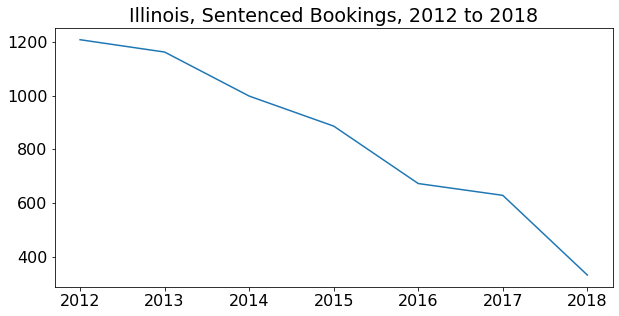

In [5]:
yearly_Sent_Booked = sentenced['booking_year'].value_counts()

linbin = np.arange(2012, 2019, 1)
fig = plt.figure(figsize = (10,10))

grid = plt.GridSpec(2,2, hspace = 0.1, wspace = 0.2, figure = fig)

fig.add_subplot(grid[1,0:], title = "Illinois, Sentenced Bookings, 2012 to 2018")
plt.plot(linbin, yearly_Sent_Booked)

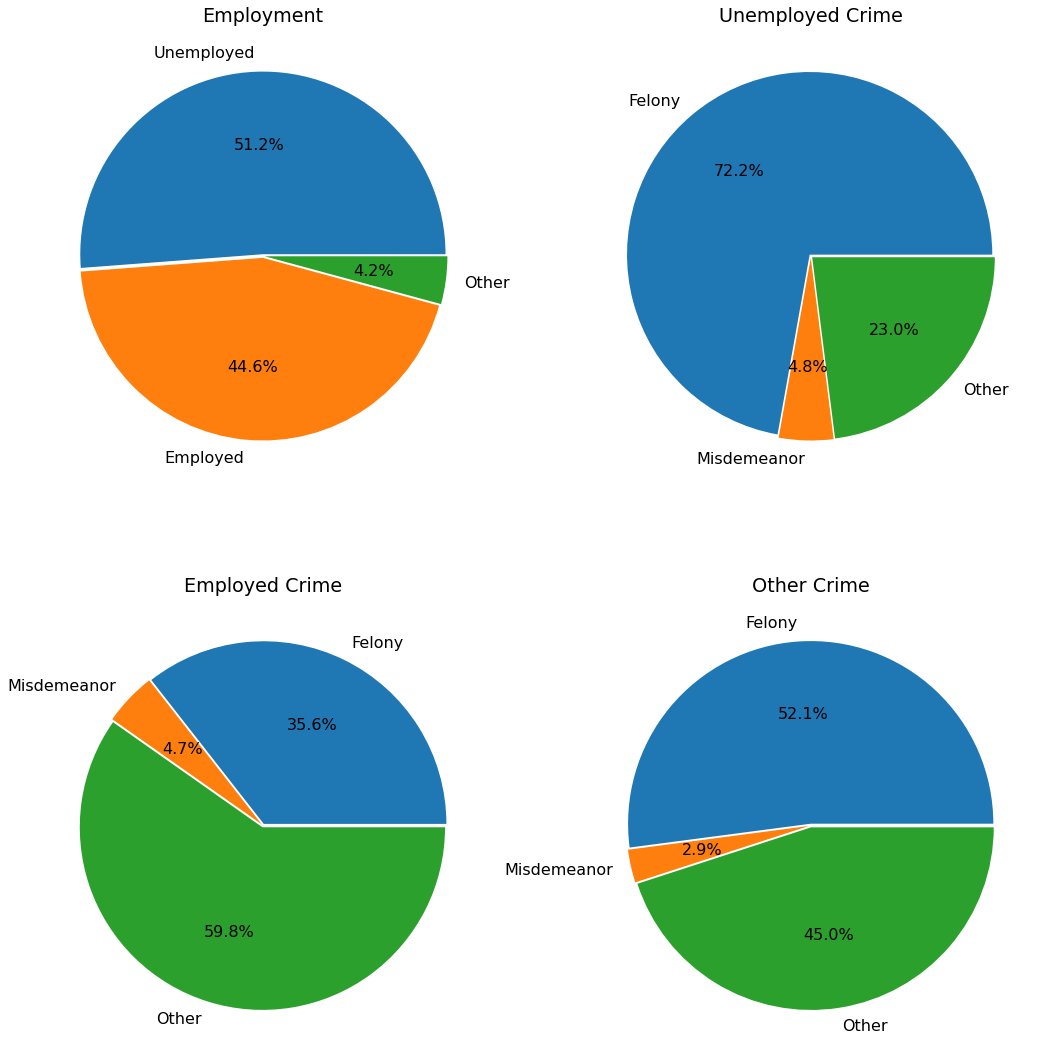

In [6]:
employment = sentenced.groupby('employment_status')

unemployed = employment.get_group('Unemployed')
employed = pd.concat([
    employment.get_group("Employed - Full Time"), 
    employment.get_group("Employed - Part Time"), 
    employment.get_group("Self Employed")
])

other = pd.concat([
    employment.get_group("Student"), 
    employment.get_group("UNKNOWN"), 
    employment.get_group("Retired"),
    employment.get_group("Laid Off")
])

emp_Totals = [len(unemployed), len(employed), len(other)]
emp_Labels = ["Unemployed", "Employed", "Other"]

fig = plt.figure(figsize = (18,20))
grid = plt.GridSpec(2,2, hspace = 0.1, wspace = 0.2, figure = fig)

unemp_Crimes_Group = unemployed.groupby("offense_level")
emp_Crimes_Group = employed.groupby("offense_level")
other_Crimes_Group = other.groupby("offense_level")

unemp_Felonies = unemp_Crimes_Group.get_group("Felony")
unemp_Misdemeanor = unemp_Crimes_Group.get_group("Misdemeanor")
unemp_Other = pd.concat([
    unemp_Crimes_Group.get_group("Can't Classify"),
    unemp_Crimes_Group.get_group("NOT CLASSIFIED"),
    unemp_Crimes_Group.get_group("UNKNOWN"), 
    unemp_Crimes_Group.get_group("Other (OV, Civil)")])

emp_Felonies = emp_Crimes_Group.get_group("Felony")
emp_Misdemeanor = emp_Crimes_Group.get_group("Misdemeanor")
emp_Other = pd.concat([
    emp_Crimes_Group.get_group("Can't Classify"),
    emp_Crimes_Group.get_group("UNKNOWN"), 
    emp_Crimes_Group.get_group("Other (OV, Civil)")])

other_Felonies = other_Crimes_Group.get_group("Felony")
other_Misdemeanor = other_Crimes_Group.get_group("Misdemeanor")
other_Other = pd.concat([
    other_Crimes_Group.get_group("Can't Classify"),
    #other_Crimes_Group.get_group("UNKNOWN"), 
    other_Crimes_Group.get_group("Other (OV, Civil)")])

unemp_Crime_Counts = [len(unemp_Felonies), len(unemp_Misdemeanor), len(unemp_Other)]
emp_Crime_Counts = [len(emp_Felonies), len(emp_Misdemeanor), len(emp_Other)]
other_Crime_Counts = [len(other_Felonies), len(other_Misdemeanor), len(other_Other)]
crime_Labels = ["Felony", "Misdemeanor", "Other"]

fig.add_subplot(grid[0,0], title = "Employment")
plt.pie(emp_Totals, labels = emp_Labels, autopct='%1.1f%%', textprops={'fontsize': 16}, explode = (0.01, 0.01, 0.01));

fig.add_subplot(grid[0,1], title = "Unemployed Crime")
plt.pie(unemp_Crime_Counts, labels = crime_Labels, autopct='%1.1f%%', textprops={'fontsize': 16}, explode = (0.01, 0.01, 0.01));

fig.add_subplot(grid[1,0], title = "Employed Crime")
plt.pie(emp_Crime_Counts, labels = crime_Labels, autopct='%1.1f%%', textprops={'fontsize': 16}, explode = (0.01, 0.01, 0.01));

fig.add_subplot(grid[1,1], title = "Other Crime")
plt.pie(other_Crime_Counts, labels = crime_Labels, autopct='%1.1f%%', textprops={'fontsize': 16}, explode = (0.01, 0.01, 0.01));

The above is remarkable, as unemployment appears to approximately <b>double</b> the odds that a given criminal is going to commit a felony as opposed to something less extreme. This is significant, though not entirely unsurprising.

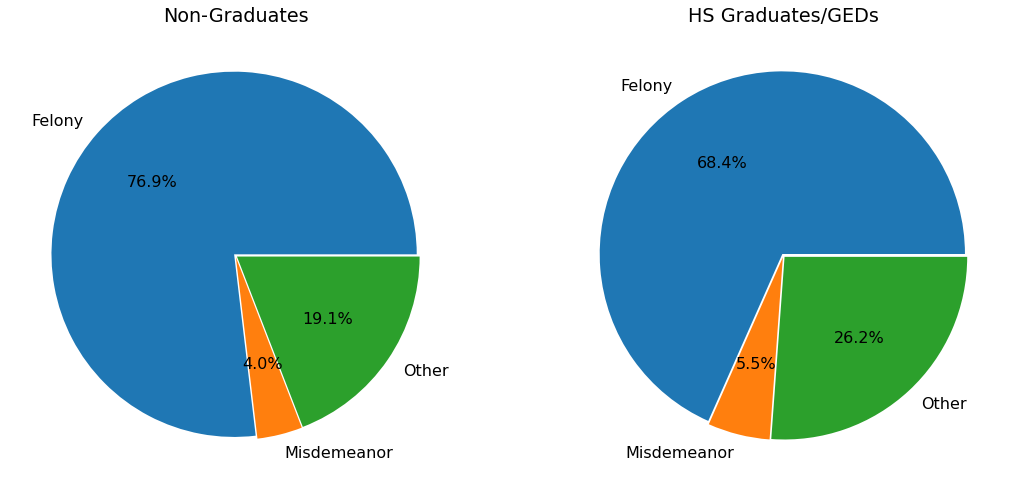

In [7]:
fig = plt.figure(figsize = (18,20))
grid = plt.GridSpec(2,2, hspace = 0.1, wspace = 0.2, figure = fig)

schooling = unemployed.groupby("education_status")
school_NonGrad = pd.concat([schooling.get_group("UNKNOWN"), schooling.get_group("NOT CLASSIFIED"), schooling.get_group("Some School ")])
school_Grad = pd.concat([schooling.get_group("GED"), schooling.get_group("High School Graduate")])

nonGrad_Groups = school_NonGrad.groupby("offense_level")
Grad_Groups = school_Grad.groupby("offense_level")

nonGrad_Felonies = nonGrad_Groups.get_group("Felony")
nonGrad_Misdemeanor = nonGrad_Groups.get_group("Misdemeanor")
nonGrad_Other = pd.concat([
    nonGrad_Groups.get_group("Can't Classify"),
    nonGrad_Groups.get_group("NOT CLASSIFIED"),
    nonGrad_Groups.get_group("UNKNOWN"), 
    nonGrad_Groups.get_group("Other (OV, Civil)")])

Grad_Felonies = Grad_Groups.get_group("Felony")
Grad_Misdemeanor = Grad_Groups.get_group("Misdemeanor")
Grad_Other = pd.concat([
    Grad_Groups.get_group("Can't Classify"),
    Grad_Groups.get_group("NOT CLASSIFIED"),
    Grad_Groups.get_group("UNKNOWN"), 
    Grad_Groups.get_group("Other (OV, Civil)")])

school_NonGrad_Counts = [len(nonGrad_Felonies),len(nonGrad_Misdemeanor),len(nonGrad_Other)]
school_Grad_Counts = [len(Grad_Felonies),len(Grad_Misdemeanor),len(Grad_Other)]
crime_Labels = ["Felony", "Misdemeanor", "Other"]

#pd.unique(unemployed['education_status'])

fig.add_subplot(grid[0,0], title = "Non-Graduates")
plt.pie(school_NonGrad_Counts, labels = crime_Labels, autopct='%1.1f%%', textprops={'fontsize': 16}, explode = (0.01, 0.01, 0.01));

fig.add_subplot(grid[0,1], title = "HS Graduates/GEDs")
plt.pie(school_Grad_Counts, labels = crime_Labels, autopct='%1.1f%%', textprops={'fontsize': 16}, explode = (0.01, 0.01, 0.01));

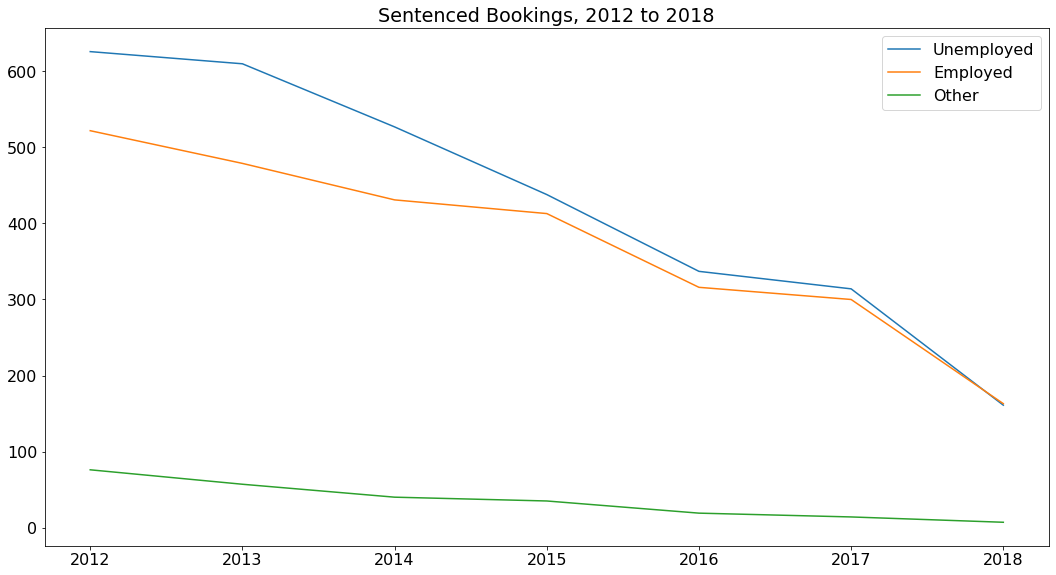

In [8]:
yearly_Unemployed = unemployed['booking_year'].value_counts()
yearly_Employed = employed['booking_year'].value_counts()
yearly_Other = other['booking_year'].value_counts()



linbin = np.arange(2012, 2019, 1)
fig = plt.figure(figsize = (18,20))

grid = plt.GridSpec(2,2, hspace = 0.1, wspace = 0.2, figure = fig)

fig.add_subplot(grid[1,0:], title = "Sentenced Bookings, 2012 to 2018")
plt.plot(linbin, yearly_Unemployed, label = 'Unemployed')
plt.plot(linbin, yearly_Employed, label = 'Employed')
plt.plot(linbin, yearly_Other, label = 'Other')
plt.legend()

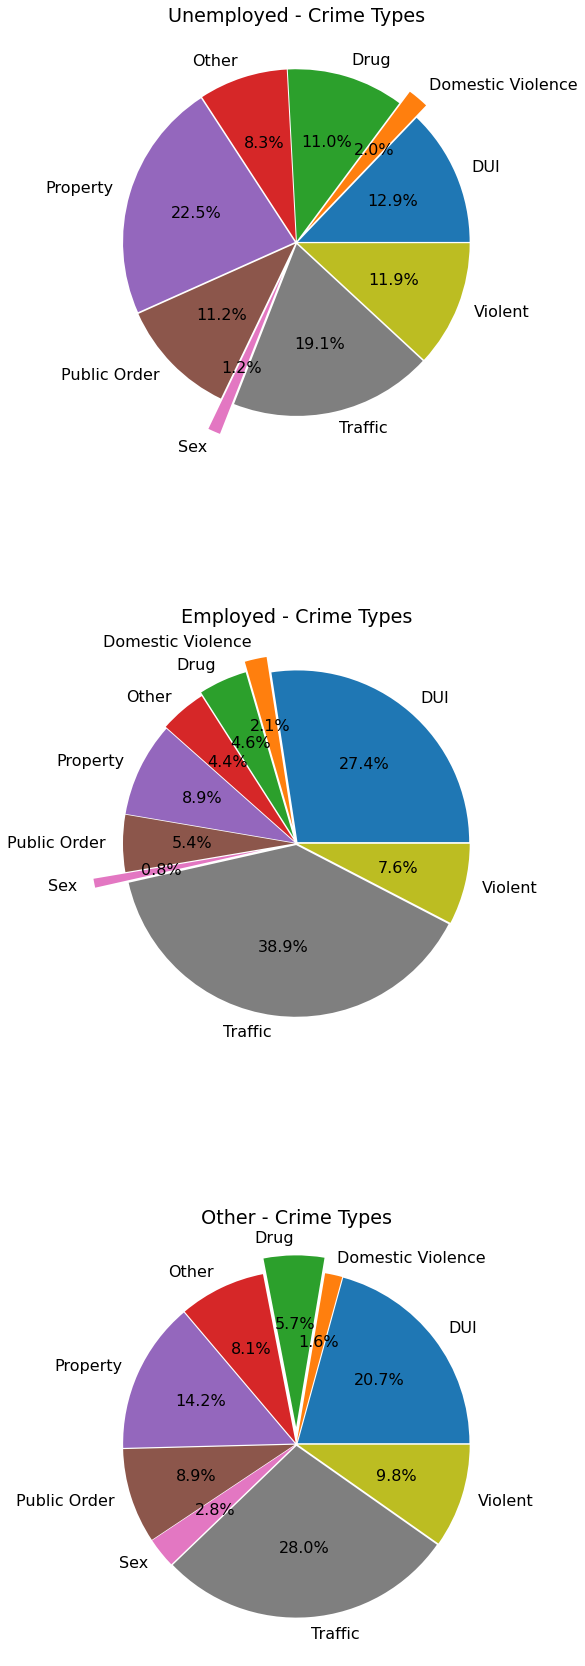

In [9]:
fig = plt.figure(figsize = (28,30))
grid = plt.GridSpec(3,1, hspace = 0.4, wspace = 0.2, figure = fig)

types_Unemployed = unemployed['superhighlevel'].value_counts()
types_Unemployed.drop(labels=["UNKNOWN"], inplace=True)
types_Unemployed.sort_index(inplace=True,ascending=True)

types_Employed = employed['superhighlevel'].value_counts()
types_Employed.drop(labels=["UNKNOWN"], inplace=True)
types_Employed.sort_index(inplace=True,ascending=True)

types_Other = other['superhighlevel'].value_counts()
types_Other.drop(labels=["UNKNOWN"], inplace=True)
types_Other.sort_index(inplace=True,ascending=True)

fig.add_subplot(grid[0,0], title = "Unemployed - Crime Types")
plt.pie(types_Unemployed.array, labels = types_Unemployed.keys(), autopct='%1.1f%%', explode = (0.01, 0.1, 0.01, 0.01, 0.01, 0.01, 0.2, 0.01, 0.01));

fig.add_subplot(grid[1,0], title = "Employed - Crime Types")
plt.pie(types_Employed.array, labels = types_Employed.keys(), autopct='%1.1f%%', explode = (0.01, 0.1, 0.04, 0.02, 0.01, 0.01, 0.2, 0.01, 0.01));

fig.add_subplot(grid[2,0], title = "Other - Crime Types")
plt.pie(types_Other.array, labels = types_Other.keys(), autopct='%1.1f%%', explode = (0.01, 0.01, 0.1, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01));

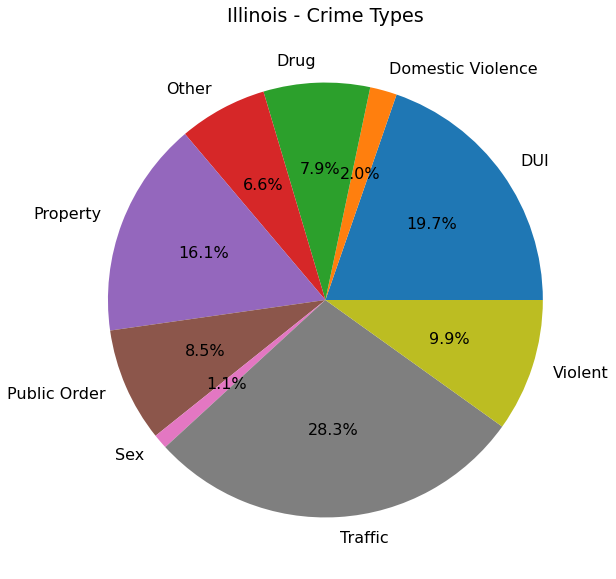

In [10]:
fig = plt.figure(figsize = (12,10))
grid = plt.GridSpec(1,1, hspace = 0.4, wspace = 0.2, figure = fig)

total_Crime = types_Unemployed + types_Employed + types_Other

fig.add_subplot(grid[0,0], title = "Illinois - Crime Types")
plt.pie(total_Crime.array, labels = total_Crime.keys(), autopct='%1.1f%%');

Because it is an often mentioned part of these statistics, we will also analyze immutable characteristics like age, biological sex, and race to look for correlations there as well. Please keep very much in mind with these that correlation is not causation on its own. At times, there may be obvious causes, while in other cases, it is more complex. I assert none of these, the statistics simply are what they are and I do not intend to make any opinionated arguments with this.

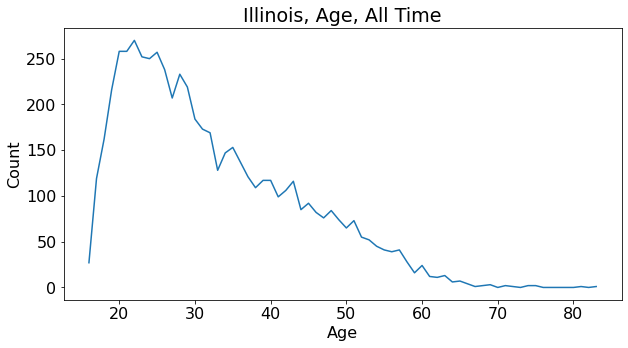

In [11]:
%%capture --no-display
fig = plt.figure(figsize = (10,5))
grid = plt.GridSpec(1,1, hspace = 0.4, wspace = 0.2, figure = fig)

sent_Age = sentenced[sentenced['age_at_arrest'] != "UNKNOWN"]
sent_Age['age_at_arrest'] = sent_Age['age_at_arrest'].astype(int)
age_Count = sent_Age['age_at_arrest'].value_counts().sort_index()

last_k = 16
for k,v in age_Count.items():
    while k > (last_k + 1):
        adder = pd.Series([0], index=[(last_k + 1)])
        age_Count = age_Count.add(adder, fill_value=0)
        last_k += 1
    last_k = k
    
fig.add_subplot(grid[0,0], title = "Illinois, Age, All Time", xlabel = 'Age', ylabel = 'Count')
plt.plot(range(sent_Age['age_at_arrest'].min() - 1, sent_Age['age_at_arrest'].max(), 1), age_Count);

According to the above, criminality appears to correlate negatively with increased age. I don't believe this is particularly surprising.

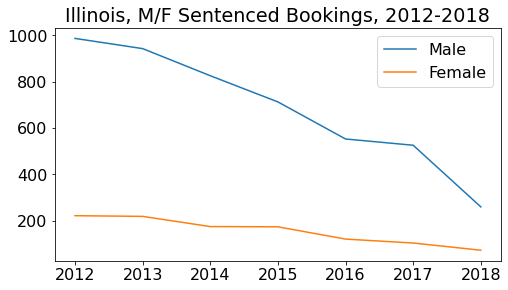

In [12]:
# race	sex	citizenship	
sexes = sentenced.groupby("sex")
male = sexes.get_group('Male')
female = sexes.get_group('Female')

yearly_Male = male['booking_year'].value_counts()
yearly_Female = female['booking_year'].value_counts()



linbin = np.arange(2012, 2019, 1)
fig = plt.figure(figsize = (8,9))

grid = plt.GridSpec(2,2, hspace = 0.1, wspace = 0.2, figure = fig)

fig.add_subplot(grid[1,0:], title = "Illinois, M/F Sentenced Bookings, 2012-2018")
plt.plot(linbin, yearly_Male, label = 'Male')
plt.plot(linbin, yearly_Female, label = 'Female')
plt.legend()

The above graph seems to indicate that while there was a discrepency between Male and Female, both appear to be following prior trends in reduced criminality, however, the slope of the Male line is significantly higher, heading very quickly towards parity with the Female line. This is a far more aggressive change than with the New York data, and I did not expect it to be this significant.

Presuming the many implications that come with this are true, it may even warrant reconsideration of some of our societal presumptions should it hold true with other datasets. Very interesting.

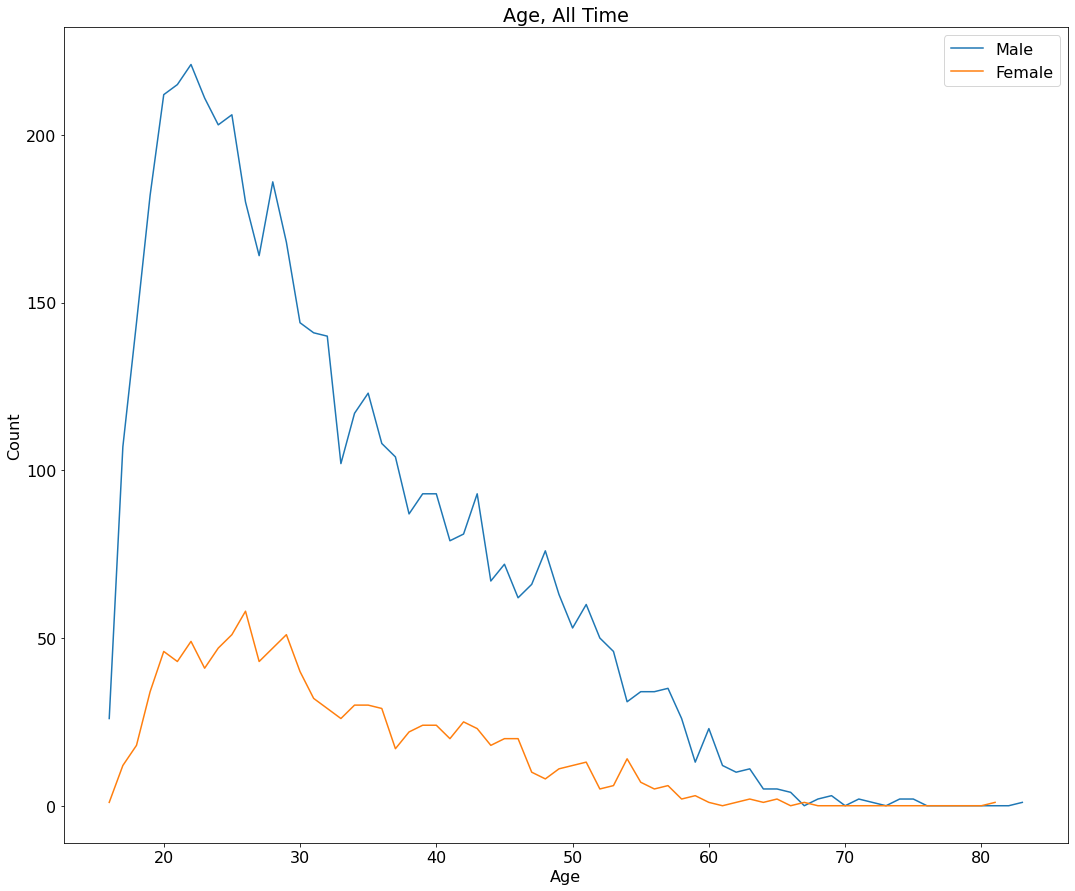

In [13]:
%%capture --no-display
fig = plt.figure(figsize = (18,15))
grid = plt.GridSpec(1,1, hspace = 0.4, wspace = 0.2, figure = fig)

sent_Age_Male = male[male['age_at_arrest'] != "UNKNOWN"]
sent_Age_Male['age_at_arrest'] = sent_Age['age_at_arrest'].astype(int)
age_Count_Male = sent_Age_Male['age_at_arrest'].value_counts().sort_index()

sent_Age_Female = female[female['age_at_arrest'] != "UNKNOWN"]
sent_Age_Female['age_at_arrest'] = sent_Age_Female['age_at_arrest'].astype(int)
age_Count_Female = sent_Age_Female['age_at_arrest'].value_counts().sort_index()

last_k = 16
for k,v in age_Count_Male.items():
    while k > (last_k + 1):
        adder = pd.Series([0], index=[(last_k + 1)])
        age_Count_Male = age_Count_Male.add(adder, fill_value=0)
        last_k += 1
    last_k = k
    
last_k = 16
for k,v in age_Count_Female.items():
    while k > (last_k + 1):
        adder = pd.Series([0], index=[(last_k + 1)])
        age_Count_Female = age_Count_Female.add(adder, fill_value=0)
        last_k += 1
    last_k = k

fig.add_subplot(grid[0,0], title = "Age, All Time", xlabel = 'Age', ylabel = 'Count')
plt.plot(range(sent_Age_Male['age_at_arrest'].min() - 1, sent_Age_Male['age_at_arrest'].max(), 1), age_Count_Male, label = 'Male');
plt.plot(range(sent_Age_Female['age_at_arrest'].min() - 1, sent_Age_Female['age_at_arrest'].max(), 1), age_Count_Female, label = 'Female');
plt.legend()

The above appears to match expectations, and is overall not that remarkable. Younger people committing more crime is entirely anticipated.

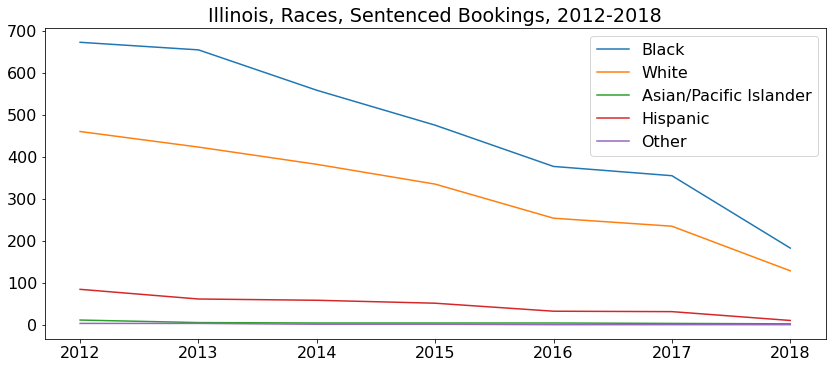

In [14]:
race = sentenced.groupby("race")
pd.unique(sentenced['race'])

race_Black = race.get_group('Black')
race_White = race.get_group('White')
race_AsianPI = race.get_group('Asian/Pacific Islander')
race_Hispanic = race.get_group('Hispanic')
race_Other = pd.concat([
    race.get_group('UNKNOWN'),
    race.get_group('Unknown')])

yearly_Black = race_Black['booking_year'].value_counts()
yearly_White = race_White['booking_year'].value_counts()
yearly_AsianPI = race_AsianPI['booking_year'].value_counts()
yearly_Hispanic = race_Hispanic['booking_year'].value_counts()
yearly_Other = race_Other['booking_year'].value_counts()



linbin = np.arange(2012, 2019, 1)
fig = plt.figure(figsize = (14,12))
grid = plt.GridSpec(2,2, hspace = 0.1, wspace = 0.2, figure = fig)


fig.add_subplot(grid[1,0:], title = "Illinois, Races, Sentenced Bookings, 2012-2018")
plt.plot(linbin, yearly_Black, label = 'Black')
plt.plot(linbin, yearly_White, label = 'White')
plt.plot(linbin, yearly_AsianPI, label = 'Asian/Pacific Islander')
plt.plot(linbin, yearly_Hispanic, label = 'Hispanic')
plt.plot(linbin, yearly_Other, label = 'Other')
plt.legend()

This matches up with expectations in relation to the NY data. Specifically, it shows that not only are over-represented (relative to population) groups decreasing along with all the others, but at an increased rate as well. This is something that is probably worth investigating to find out what changed, so next we'll look at unemployment year over year for the two largest sets.

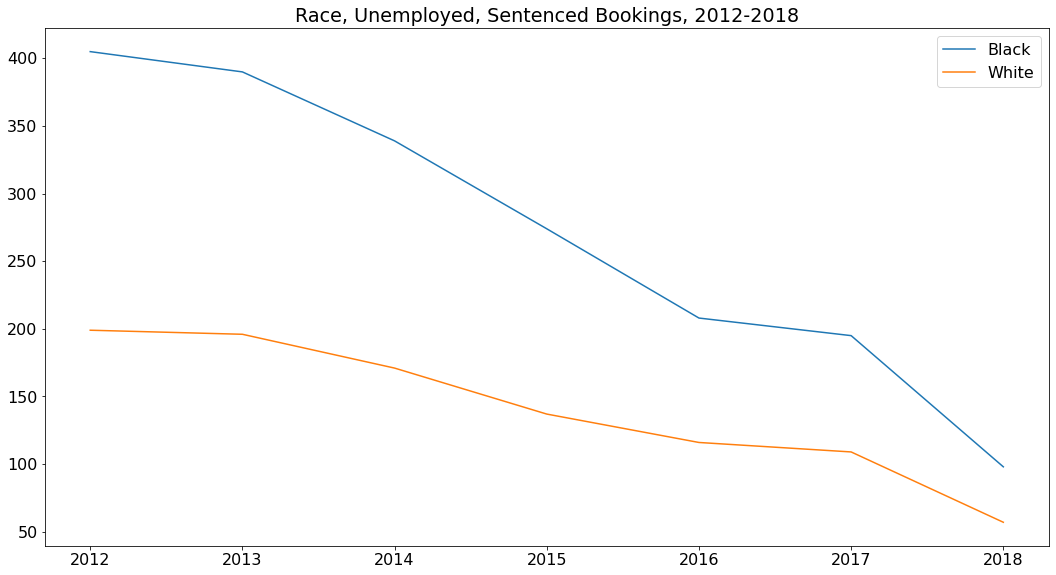

In [17]:
black_Employment = race_Black.groupby('employment_status')
white_Employment = race_White.groupby('employment_status')

black_Unemployed = black_Employment.get_group('Unemployed')
white_Unemployed = white_Employment.get_group('Unemployed')

yearly_Black_Unemployed = black_Unemployed['booking_year'].value_counts()
yearly_White_Unemployed = white_Unemployed['booking_year'].value_counts()

linbin = np.arange(2012, 2019, 1)
fig = plt.figure(figsize = (18,20))
grid = plt.GridSpec(2,2, hspace = 0.1, wspace = 0.2, figure = fig)

fig.add_subplot(grid[1,0:], title = "Race, Unemployed, Sentenced Bookings, 2012-2018")
plt.plot(linbin, yearly_Black_Unemployed, label = 'Black')
plt.plot(linbin, yearly_White_Unemployed, label = 'White')
plt.legend()

This should not be misinterpreted to say that unemployment is down - this data does not say that. In fact, it doesn't say much, it just implies there's some correlation between unemployment and overall numbers, since the two graphs track, but we'll need to look at the ratio for that, which we'll do next.

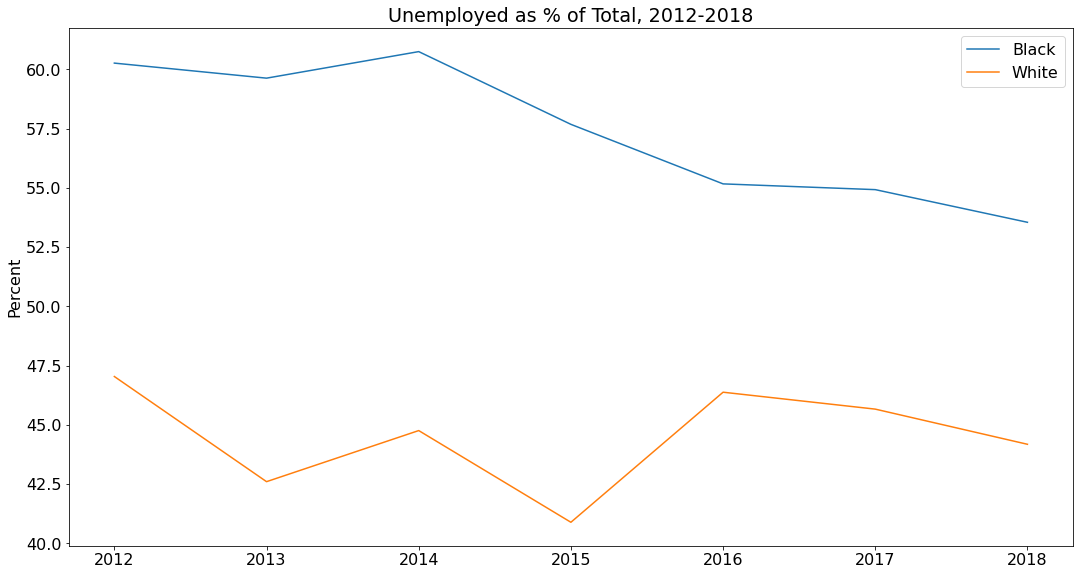

In [16]:
yearly_White_Ratio = (yearly_White_Unemployed / yearly_White)
yearly_Black_Ratio = (yearly_Black_Unemployed / yearly_Black)

fig = plt.figure(figsize = (18,20))
grid = plt.GridSpec(2,2, hspace = 0.1, wspace = 0.2, figure = fig)

fig.add_subplot(grid[1,0:], title = "Unemployed as % of Total, 2012-2018", ylabel="Percent")
plt.plot(linbin, yearly_Black_Ratio*100, label = 'Black')
plt.plot(linbin, yearly_White_Ratio*100, label = 'White')
plt.legend()

This plot appears to imply that while the second largest group, Whites, have an approximately stable ratio (anywhere from 40-47.5%) despite the decline in overall prison population. However, the largest group, Blacks, who by comparison are over-represented do <b>not</b> have a stable ratio and this ratio is also declining. I can't say precisely what that means, but it warrants deeper investigation, though that is outside the scope and capabilities of this analysis.